# Predicting House Sale Prices

In this project I will be working with housing data for the city of Ames, Iowa, United States from 2006 to 2010. I'll begin by setting up a pipeline of functions that will let me quickly iterate on different models.

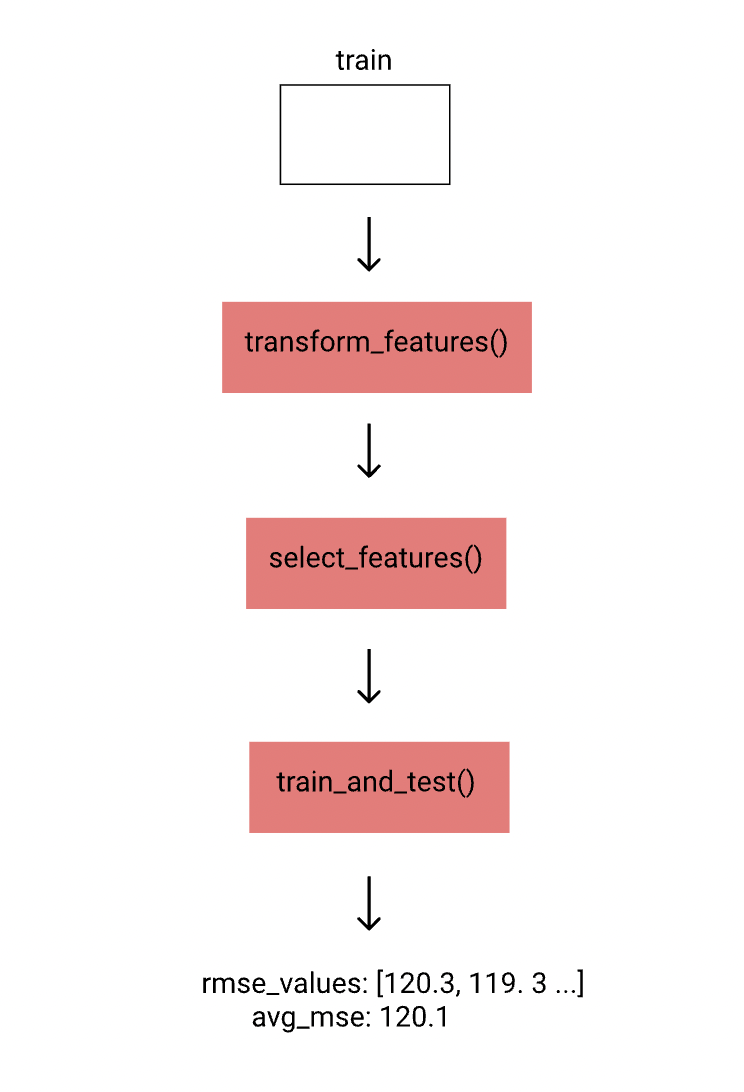

In [26]:
import pandas as pd
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [16]:
data = pd.read_csv('AmesHousing.tsv', sep='\t')

In [17]:
def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse   

57088.251612639084

## Feature Engineering
- Handle missing values:
    - All columns:
        - Drop any with 5% or more missing values for now.
    - Text columns:
        - Drop any with 1 or more missing values for now.
    - Numerical columns:
        - For columns with missing values, fill in with the most common value in that column

In [22]:
def transform_features(df):
    new_df = df
    numerics_df = new_df.select_dtypes(include=['integer', 'float'])

    for idx, row in ((numerics_df.isnull().sum())/len(numerics_df)).iteritems():
        if 0 < row < 0.05:
            idx = str(idx)
            new_df[idx] = numerics_df[idx].fillna(mode(numerics_df[idx]))
        elif row > 0.05:
            new_df = new_df.drop(columns = idx)
        else: pass
        
    for idx, row in ((new_df.isnull().sum())/len(new_df)).iteritems():
        if row > 0.05:
            new_df = new_df.drop(columns = idx)        
        else: pass
    
    new_df['Years Since Remod'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df['Years Before Sale'] = new_df['Yr Sold'] - new_df['Year Remod/Add']

    new_df = new_df.dropna(axis=0)
    new_df = new_df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    new_df = new_df.drop([850,2180,1702,2181], axis=0)

    new_df = new_df.drop(columns = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'])

    new_df = new_df.drop(["PID", "Order"], axis=1)
    
    return new_df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse  

53589.61014617297

## Feature Selection

Now that I have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

In [24]:
def transform_features(df):
    new_df = df
    numerics_df = new_df.select_dtypes(include=['integer', 'float'])

    for idx, row in ((numerics_df.isnull().sum())/len(numerics_df)).iteritems():
        if 0 < row < 0.05:
            idx = str(idx)
            new_df[idx] = numerics_df[idx].fillna(mode(numerics_df[idx]))
        elif row > 0.05:
            new_df = new_df.drop(columns = idx)
        else: pass
        
    for idx, row in ((new_df.isnull().sum())/len(new_df)).iteritems():
        if row > 0.05:
            new_df = new_df.drop(columns = idx)        
        else: pass
    
    new_df['Years Since Remod'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df['Years Before Sale'] = new_df['Yr Sold'] - new_df['Year Remod/Add']

    new_df = new_df.dropna(axis=0)
    new_df = new_df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    new_df = new_df.drop([850,2180,1702,2181], axis=0)

    new_df = new_df.drop(columns = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'])

    new_df = new_df.drop(["PID", "Order"], axis=1)
    
    return new_df

def select_features(df):
    
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse  

27087.950448929987

## Train And Test

In [43]:
def transform_features(df):
    new_df = df
    numerics_df = new_df.select_dtypes(include=['integer', 'float'])

    for idx, row in ((numerics_df.isnull().sum())/len(numerics_df)).iteritems():
        if 0 < row < 0.05:
            idx = str(idx)
            new_df[idx] = numerics_df[idx].fillna(mode(numerics_df[idx]))
        elif row > 0.05:
            new_df = new_df.drop(columns = idx)
        else: pass
        
    for idx, row in ((new_df.isnull().sum())/len(new_df)).iteritems():
        if row > 0.05:
            new_df = new_df.drop(columns = idx)        
        else: pass
    
    new_df['Years Since Remod'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df['Years Before Sale'] = new_df['Yr Sold'] - new_df['Year Remod/Add']

    new_df = new_df.dropna(axis=0)
    new_df = new_df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    new_df = new_df.drop([850,2180,1702,2181], axis=0)

    new_df = new_df.drop(columns = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'])

    new_df = new_df.drop(["PID", "Order"], axis=1)
    
    return new_df

def select_features(df):
    
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df,k):  
    
    df = df.select_dtypes(include=['integer', 'float'])
    features = df.columns.drop("SalePrice")
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        lr = LinearRegression()
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    elif k > 0:
        
        kfold = KFold(n_splits=k, shuffle=True)
        
        for train, test in kfold.split(df):
            
            train = df.iloc[train]
            test = df.iloc[test]
            
            lr = LinearRegression()
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            
            return print('When K is {} RMSE is {}. \n'.format(k, rmse))

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,3)

rmse 

When K is 3 RMSE is 34600.7680065245. 

